# Homework 3: MNIST Image Classifer

## Setup

In [1]:
# Import fastai, but only for the DataBlock part.
from fastai.vision.all import *

path = untar_data(URLs.MNIST)

# Create a subset of the images, so we train faster. We do this by taking 500 random images of each digit.
set_seed(0)
num_imgs_per_digit = 500
items = [
    p
    for split in ['training', 'testing']
    for digit in range(10)
    for p in (path/split/str(digit)).ls().shuffle()[:num_imgs_per_digit]
]

# Create the `dataloaders`. We need a slightly special `ImageBlock` because we want grayscale images.

block = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    get_y = parent_label,
    splitter=GrandparentSplitter(train_name='training', valid_name="testing"),
)
dataloaders = block.dataloaders(items, bs=16)
print(f"{dataloaders.train.n} training images, {dataloaders.valid.n} validation images")

5000 training images, 5000 validation images


## Single Layer Model

In [2]:
# Flatten each image, removing the spacial structure
flattener = nn.Flatten()

# Create the linear layer
linear_1 = nn.Linear(in_features=784, out_features=10, bias=False)

In [3]:
# Create model for single linear layer
model_1 = nn.Sequential(
    flattener,
    linear_1,
)
model_1.to(dataloaders.device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=False)
)

Epoch  0: loss=0.59, train accuracy 4092/4992
Epoch  1: loss=0.48, train accuracy 4429/4992
Epoch  2: loss=0.43, train accuracy 4493/4992
Epoch  3: loss=0.40, train accuracy 4541/4992
Epoch  4: loss=0.37, train accuracy 4596/4992
Epoch  5: loss=0.36, train accuracy 4590/4992
Epoch  6: loss=0.34, train accuracy 4615/4992
Epoch  7: loss=0.33, train accuracy 4644/4992
Epoch  8: loss=0.32, train accuracy 4663/4992
Epoch  9: loss=0.31, train accuracy 4686/4992
Epoch 10: loss=0.30, train accuracy 4697/4992
Epoch 11: loss=0.29, train accuracy 4704/4992
Epoch 12: loss=0.28, train accuracy 4721/4992
Epoch 13: loss=0.28, train accuracy 4716/4992
Epoch 14: loss=0.27, train accuracy 4724/4992
Epoch 15: loss=0.27, train accuracy 4748/4992
Epoch 16: loss=0.24, train accuracy 4755/4992
Epoch 17: loss=0.23, train accuracy 4753/4992
Epoch 18: loss=0.22, train accuracy 4770/4992
Epoch 19: loss=0.21, train accuracy 4753/4992


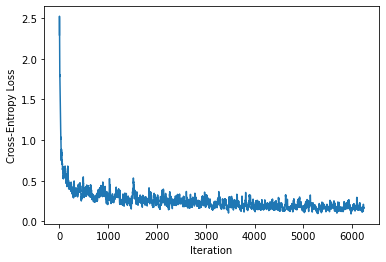

In [4]:
num_epochs=20
learning_rate=0.3
losses=[]

linear_1.reset_parameters()

for epoch in range(num_epochs):
    total_images = 0
    total_correct = 0
    
    for images, labels in dataloaders.train:
        images = cast(images, Tensor)
        labels = cast(labels, Tensor)
        
        logits = model_1(images)
        loss = F.cross_entropy(logits, labels, reduction='none').mean()
        
        loss.backward()
        for parameter in model_1.parameters():
            parameter.data -= learning_rate * parameter.grad
        model_1.zero_grad()
        
        # Track the metrics of the model
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images += len(labels)
        total_correct += num_accurate
        
        losses.append(loss.item())
        
    avg_loss_this_epoch = np.mean(losses[-total_images:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, train accuracy {total_correct:3d}/{total_images}")

# Plot the smoothed loss
pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");

## Two-Layer Model

In [5]:
# Defining the layers
linear_1 = nn.Linear(in_features=784, out_features=30)
relu_layer = nn.ReLU()
linear_2 = nn.Linear(in_features=30, out_features=10)

In [6]:
# Create two-layer model
model_2 = nn.Sequential(
    flattener,
    linear_1,
    relu_layer,
    linear_2
)
model_2.to(dataloaders.device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)

Epoch  0: loss=0.70, training accuracy: 3840/4992
Epoch  1: loss=0.52, training accuracy: 4483/4992
Epoch  2: loss=0.42, training accuracy: 4607/4992
Epoch  3: loss=0.36, training accuracy: 4726/4992
Epoch  4: loss=0.32, training accuracy: 4755/4992
Epoch  5: loss=0.29, training accuracy: 4798/4992
Epoch  6: loss=0.26, training accuracy: 4839/4992
Epoch  7: loss=0.23, training accuracy: 4882/4992
Epoch  8: loss=0.21, training accuracy: 4919/4992
Epoch  9: loss=0.20, training accuracy: 4925/4992
Epoch 10: loss=0.18, training accuracy: 4940/4992
Epoch 11: loss=0.17, training accuracy: 4970/4992
Epoch 12: loss=0.16, training accuracy: 4986/4992
Epoch 13: loss=0.15, training accuracy: 4988/4992
Epoch 14: loss=0.14, training accuracy: 4991/4992
Epoch 15: loss=0.13, training accuracy: 4991/4992
Epoch 16: loss=0.08, training accuracy: 4992/4992
Epoch 17: loss=0.06, training accuracy: 4992/4992
Epoch 18: loss=0.05, training accuracy: 4992/4992
Epoch 19: loss=0.04, training accuracy: 4992/4992


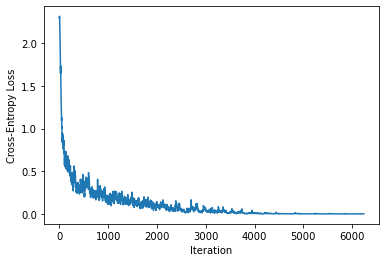

In [10]:
num_epochs=20
learning_rate=0.3
losses=[]

linear_1.reset_parameters()
linear_2.reset_parameters()

for epoch in range(num_epochs):
    total_images = 0
    total_correct = 0
    
    for images, labels in dataloaders.train:
        images = cast(images, Tensor)
        labels = cast(labels, Tensor)
        
        logits = model_2(images)
        loss = F.cross_entropy(logits, labels, reduction='none').mean()
        
        loss.backward()
        for parameter in model_2.parameters():
            parameter.data -= learning_rate * parameter.grad
        model_2.zero_grad()
        
        # Track the metrics of the model
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images += len(labels)
        total_correct += num_accurate
        
        losses.append(loss.item())
        
    avg_loss_this_epoch = np.mean(losses[-total_images:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, training accuracy: {total_correct:3d}/{total_images}")

# Plot the smoothed loss
pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");

## Analysis/Reflection

With around 0.04 as the loss for the two-layer model, and around 0.21 for the logistic regression model, the two layer model did significantly better than the single layer model. I found that for both models, a learning rate of 0.3 was appropriate, and also used 20 epochs for each. 

**- What did you learn about neural networks from this exercise?**

I mostly learned about the impressive capabilities of a neural network compared to linear regression. I also learned some about picking learning rates/epochs, as I had to decide which rates worked best.

**- What did you learn about your own problem-solving process?**

I learned that I rely a lot on the notebooks from class rather than materials online. I found the lab 5 mnist classifier to be helpful. This also made me less likely to look up specific functions of PyTorch and understand them on a deeper level, so on my own time I might want to try some of the optional extensions to this homework.

**- How would you describe this experience in a job interview?**

In a job interview, I would probably talk about the differences between creating a linear model and a two-layer model, and how the results ended up as they did, and then what I learned from those results.